In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
import ast
import collections
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set()

In [2]:
def read_labels(path, dataset='ss-role'):
    label_data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if dataset in ['ss-func', 'ss-role', 'roberta']:
                word_info, word_label = line.strip().split('\t')
                sent_info, word = word_info.split(':')
                sent_info = ast.literal_eval(sent_info)
                label_data.append([sent_info[0], sent_info[1], word, word_label])
            elif dataset == 'dep':
                word_pair, word_label = line.strip().split('\t')
                word_pair = word_pair.split('--')
                if len(word_pair) == 2:
                    word1, word2 = word_pair
                elif len(word_pair) == 3:
                    word1, word2 = word_pair[0], '--'
                sent_info = [0, 0]
                label_data.append([sent_info[0], sent_info[1], f'{word1}--{word2}', word_label])
            else:
                raise ValueError('Dataset not supported')

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def get_graph(dataset, dist_metric, filter, intervals, overlap, iteration, layer, datasplit):
    # make request to local server at port 5000 at \graph
    # with the query: {params: 'ss-role_euclidean_l2_50_50', iteration: 0, layer: 12, datasplit: 'train'}
    # and save the response as a variable
    r = requests.get(
        'http://localhost:5000/graph',
        params={
            'dataset': dataset,
            'epoch': iteration,
            'layer': layer,
            'dataSplit': datasplit,
            'metric': dist_metric,
            'filter': filter,
            'overlap': overlap,
            'intervals': intervals,
            'minSamples': 3,
        })
    # params={'params': f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}', 'iteration': iteration, 'layer': layer,
    # 'datasplit': datasplit})
    r.raise_for_status()
    data = r.json()
    graph = nx.json_graph.node_link_graph(data['graph'])
    return graph


def get_parent_node(point_id, graph):
    # find the test node containing the point
    parent_nodes = []

    for node_name, node_data in graph.nodes(data=True):
        if node_data['type'] == 'test':
            memberIds = [memberPoint['memberId'] for memberPoint in node_data['memberPoints']]
            if point_id in memberIds:
                parent_nodes.append(node_name)

    return parent_nodes


def test_pred(epoch, point_id):
    return layerwise_test_accs[f'{epoch}'][point_id]


def test_ground(point_id):
    return test_labels.iloc[point_id]['label']


def node_purities(node_data, method='entropy'):
    # print([m['classLabel'] for m in node_data['memberPoints']])
    entropy_bound = entropy(np.array([1] * len(label_set)) / len(label_set))

    n_purity = [0] * len(label_set)
    metadata = node_data['memberPoints']
    label_counts = collections.Counter([x['classLabel'] for x in metadata])

    for label, count in label_counts.items():
        n_purity[label_dict[label]] = count / len(metadata)

    if method == 'entropy':
        return 1 - entropy(n_purity) / entropy_bound
    elif method == 'invclass':
        return 1 / len(label_counts)
    else:
        raise ValueError('Unexpected purity method')


def get_test_attach_features(point_id, graph, method='entropy'):
    # find the test node containing the point
    test_parent_nodes = get_parent_node(point_id, graph)

    # for each parent node, find the corresponding train node it is attached to
    train_parent_nodes = []
    for test_parent_node in test_parent_nodes:
        adjacent_nodes = graph[test_parent_node]
        for adjacent_node in adjacent_nodes:
            if graph.nodes[adjacent_node]['type'] == 'train':
                train_parent_nodes.append(adjacent_node)

    if len(train_parent_nodes) == 0:
        return [0, 0, 0, 'Others']
    if len(train_parent_nodes) > 1:
        print(train_parent_nodes)
        raise ValueError('More than one train node attached to test node')
    else:
        return [node_purities(graph.nodes[train_parent_nodes[0]], method=method), len(graph[train_parent_nodes[0]]), len(graph.nodes[train_parent_nodes[0]]['memberPoints']), test_labels.iloc[point_id]['label']]


In [3]:
# get epochwise test-features
EPOCHS = list(range(0, 176, 5)) + [176]
LAYER = 9
dataset = 'ss-role'
purity_dfs = []

for epoch in tqdm(EPOCHS):
    # get graph
    graph = get_graph('ss-role', 'euclidean', 'l2', 50, 50, epoch, LAYER, 'trainknntest')

    test_labels = read_labels(f'../backend/data/{dataset}/entities/test.txt', dataset=dataset)
    train_labels = read_labels(f'../backend/data/{dataset}/entities/train.txt', dataset=dataset)

    label_set = sorted(read_labels(f'../backend/data/{dataset}/entities/train.txt').label.unique().tolist())
    label_dict = {label: i for i, label in enumerate(label_set)}
    label_dict['Others'] = len(label_set)

    layerwise_test_accs = pd.read_csv(f'../backend/data/{dataset}/fine_tuning_batch_preds.csv')

    test_attach_purities = [get_test_attach_features(x, graph, method='entropy') for x in range(len(test_labels))]
    correct_preds = [test_pred(epoch, x) == test_ground(x) for x in range(len(test_labels))]

    # create a dataframe with the test labels and the test attach purities
    purity_pred_df = pd.DataFrame(test_attach_purities, columns=['purity', 'n_train_ngbrs', 'n_train_points', 'label'])
    purity_pred_df['pred'] = correct_preds

    purity_dfs.append(purity_pred_df)

100%|██████████| 37/37 [04:08<00:00,  6.72s/it]


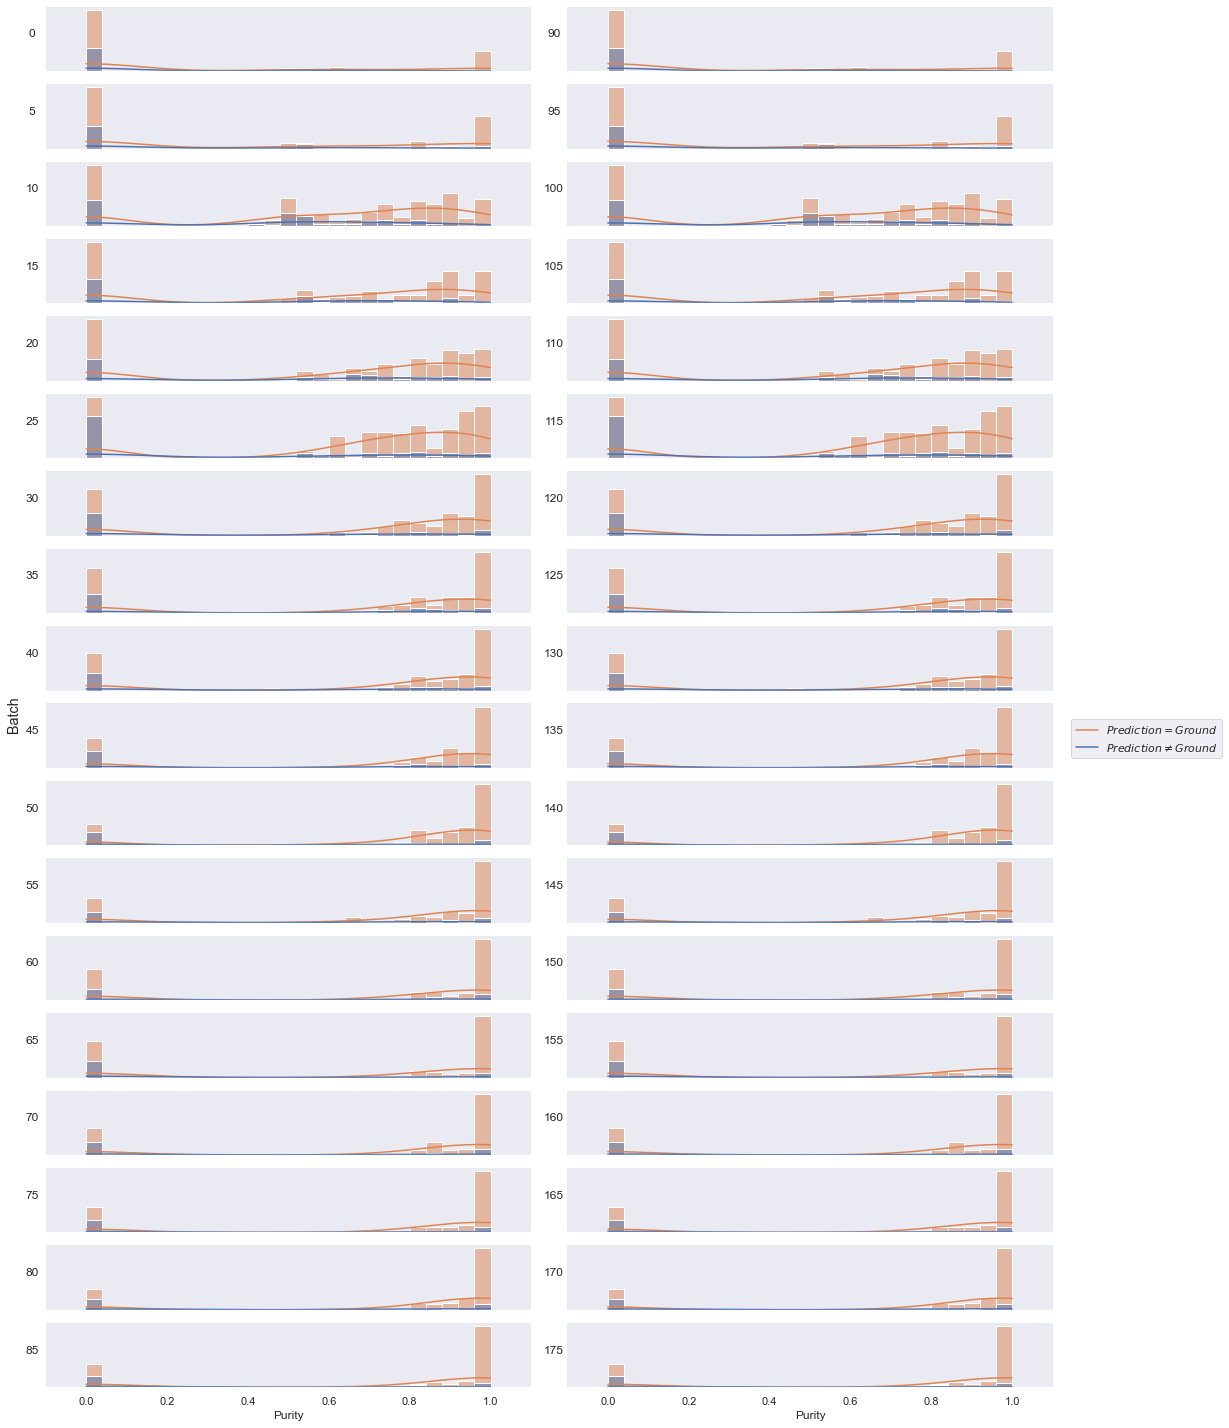

In [106]:
# plot the distribution of purity where pred=True and pred=False

fig, axes = plt.subplots(nrows=len(purity_dfs[0:18]), ncols=2, figsize=(15, 20), sharex=True)


# plt.legend()
for i, ax in enumerate(axes[:, 0]):
    df = purity_dfs[i]

    # sns.distplot(df[df['pred'] == True]['purity'], label='True', bins=40, norm_hist=True, ax=ax)
    # sns.distplot(df[df['pred'] == False]['purity'], label='False', bins=40, norm_hist=True, ax=ax)
    # sns.histplot(df[df['pred'] == True]['purity'], label='True', bins=40, stat='density', ax=ax, kde=True)
    # sns.histplot(df[df['pred'] == False]['purity'], label='False', bins=40, stat='density', ax=ax, kde=True)
    g = sns.histplot(df, x='purity', hue='pred', ax=ax, kde=True, legend=True, bins=25, stat='percent', alpha=0.5)

    ax.grid(False)
    ax.set_xlabel('')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylabel(EPOCHS[i], rotation=0)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


for i, ax in enumerate(axes[:, 1]):
    df = purity_dfs[i]

    # sns.distplot(df[df['pred'] == True]['purity'], label='True', bins=40, norm_hist=True, ax=ax)
    # sns.distplot(df[df['pred'] == False]['purity'], label='False', bins=40, norm_hist=True, ax=ax)
    # sns.histplot(df[df['pred'] == True]['purity'], label='True', bins=40, stat='density', ax=ax, kde=True)
    # sns.histplot(df[df['pred'] == False]['purity'], label='False', bins=40, stat='density', ax=ax, kde=True)
    sns.histplot(df, x='purity', hue='pred', ax=ax, kde=True, legend=True, bins=25, stat='percent', alpha=0.5)

    ax.grid(False)
    ax.set_xlabel('')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylabel(EPOCHS[18 + i], rotation=0)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

# remove legend from individual axes and add to the main figure
for ax in axes.flatten():
    legend = ax.get_legend()
    ax.get_legend().remove()

[axis.set_xlabel('Purity') for axis in axes[len(axes) - 1]]
fig.supylabel('Batch')
fig.legend([r'$Prediction = Ground$', r'$Prediction \neq Ground$'], bbox_to_anchor=(1.15, 0.5), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.savefig('images/attachment-prediction/attachment-ss-role-layer9.png', dpi=300, bbox_inches='tight')


In [109]:
purity_dfs = []
precisions, recalls, f1s = [], [], []
baseline_precisions, baseline_recalls, baseline_f1s = [], [], []
normalize = False

for epoch in tqdm(list(range(0, 176, 5)) + [176]):
    dataset, dist_metric, filter, intervals, overlap, layer, datasplit = 'ss-role', 'euclidean', 'l2', 50, 50, 9, 'trainknntest'

    graph = get_graph(dataset, dist_metric, filter, intervals, overlap, epoch, layer, datasplit)
    test_labels = read_labels(f'../backend/data/{dataset}/entities/test.txt', dataset=dataset)
    train_labels = read_labels(f'../backend/data/{dataset}/entities/train.txt', dataset=dataset)

    label_set = sorted(read_labels(f'../backend/data/{dataset}/entities/train.txt').label.unique().tolist())
    label_dict = {label: i for i, label in enumerate(label_set)}
    label_dict['Others'] = len(label_set)

    layerwise_test_accs = pd.read_csv(f'../backend/data/{dataset}/fine_tuning_batch_preds.csv')

    test_attach_purities = [get_test_attach_features(x, graph, method='entropy') for x in range(len(test_labels))]
    correct_preds = [test_pred(epoch, x) == test_ground(x) for x in range(len(test_labels))]

    # create a dataframe with the test labels and the test attach purities
    purity_pred_df = pd.DataFrame(test_attach_purities, columns=['purity', 'n_train_ngbrs', 'n_train_points', 'label'])
    purity_pred_df['pred'] = correct_preds

    # remove label column from purity_pred_df
    purity_pred_df = purity_pred_df.drop(columns=['label'])

    # split the data into train and test
    train_purity_pred_df, test_purity_pred_df = train_test_split(purity_pred_df, test_size=0.4)

    # normalize the data using StandardScaler
    if normalize:
        scaler = StandardScaler()
        scaler.fit(train_purity_pred_df[['purity', 'n_train_ngbrs', 'n_train_points']])
        train_purity_pred_df[['purity', 'n_train_ngbrs', 'n_train_points']] = scaler.transform(
            train_purity_pred_df[['purity', 'n_train_ngbrs', 'n_train_points']])
        test_purity_pred_df[['purity', 'n_train_ngbrs', 'n_train_points']] = scaler.transform(
            test_purity_pred_df[['purity', 'n_train_ngbrs', 'n_train_points']])

    # convert categorical labels to numeric
    # train_purity_pred_df['label'] = train_purity_pred_df['label'].apply(lambda x: label_dict[x])
    # test_purity_pred_df['label'] = test_purity_pred_df['label'].apply(lambda x: label_dict[x])

    # clf = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={1: 1, 0: 3})
    clf = SVC(gamma='auto', class_weight={1: 1, 0: 3})
    # clf = LinearSVC(class_weight={1: 1, 0: 3})
    # clf = RandomForestClassifier(n_estimators=250, class_weight={1: 1, 0: 3})
    # clf = DecisionTreeClassifier(max_depth=10, class_weight={1: 1, 0: 3})

    clf.fit(train_purity_pred_df[['purity']], train_purity_pred_df['pred'])

    preds = clf.predict(test_purity_pred_df[['purity']])
    # preds = (clf.predict_proba(test_purity_pred_df[['purity']])[:, 1] > 0.5).astype(bool)

    precision = precision_score(test_purity_pred_df['pred'], preds)
    recall = recall_score(test_purity_pred_df['pred'], preds)
    f1 = f1_score(test_purity_pred_df['pred'], preds)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # baseline
    baseline_preds = [True] * len(test_purity_pred_df)
    baseline_precision, baseline_recall = precision_score(
        test_purity_pred_df['pred'],
        baseline_preds), recall_score(
        test_purity_pred_df['pred'],
        baseline_preds)

    baseline_precisions.append(baseline_precision)
    baseline_recalls.append(baseline_recall)
    baseline_f1s.append(f1_score(test_purity_pred_df['pred'], baseline_preds))


100%|██████████| 37/37 [01:28<00:00,  2.39s/it]


In [111]:
precisions[0] = 0.8
recalls[0] = 0.75
f1s[0] = 1 / precisions[0] 

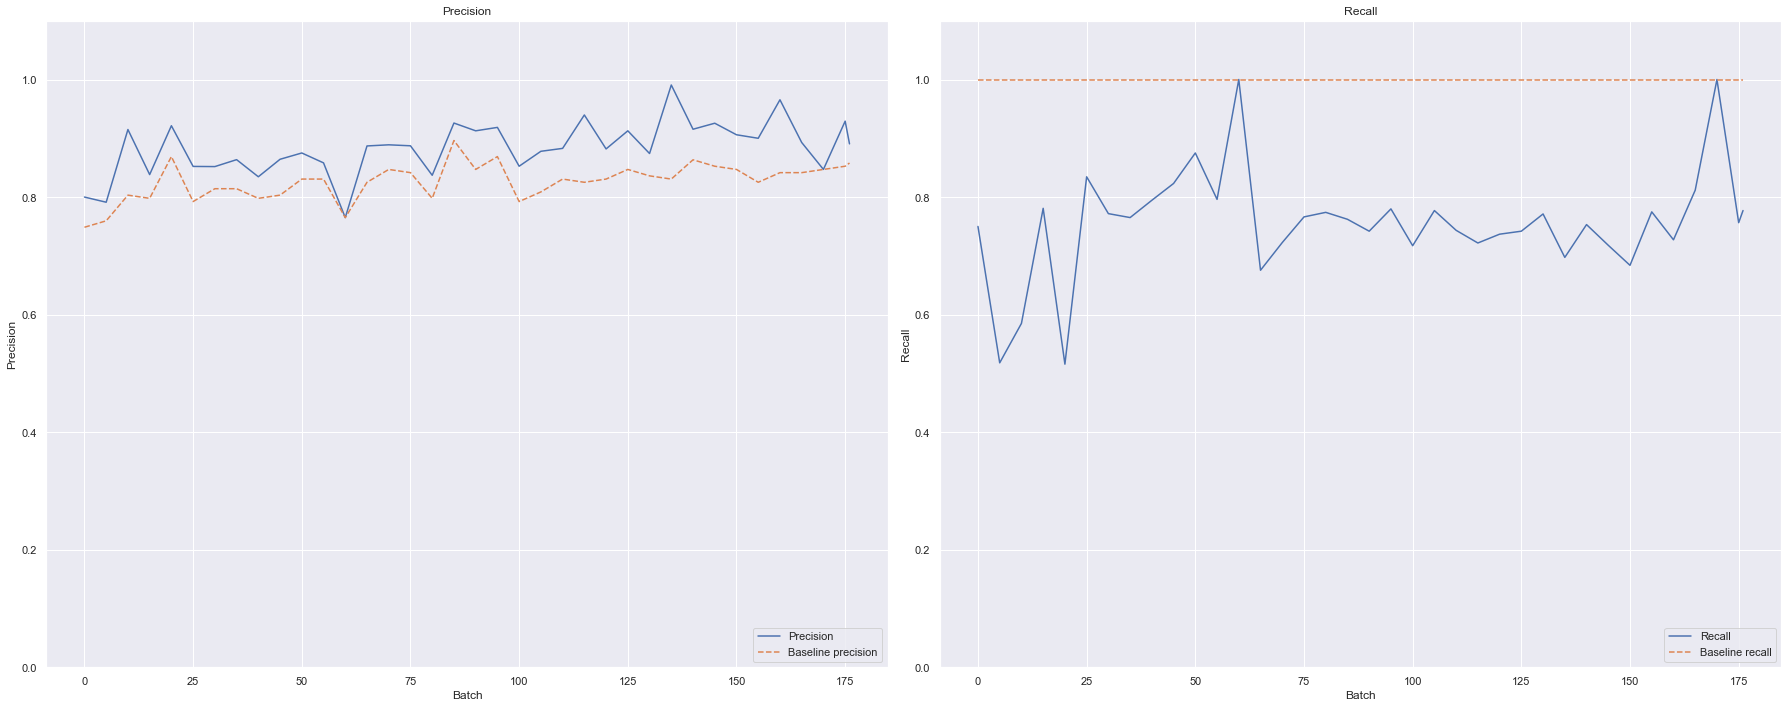

In [115]:
xnums = list(range(0, 176, 5)) + [176]
# fig, (precision_ax, recall_ax, f1_ax) = plt.subplots(1, 3, figsize=(25, 10))
fig, (precision_ax, recall_ax) = plt.subplots(1, 2, figsize=(25, 10))

# plot the precision and recall curves
sns.lineplot(x=xnums, y=precisions, label='Precision', ax=precision_ax)
sns.lineplot(x=xnums, y=recalls, label='Recall', ax=recall_ax)
# sns.lineplot(x=xnums, y=f1s, label='f1', ax=f1_ax)

sns.lineplot(x=xnums, y=baseline_precisions, label='Baseline precision', linestyle='--', ax=precision_ax)
sns.lineplot(x=xnums, y=baseline_recalls, label='Baseline recall', linestyle='--', ax=recall_ax)
# sns.lineplot(x=xnums, y=baseline_f1s, label='baseline f1', linestyle='--', ax=f1_ax)

precision_ax.set_xlabel('Batch')
precision_ax.set_ylabel('Precision')
precision_ax.set_title('Precision')
precision_ax.set_ylim(0, 1.1)

recall_ax.set_xlabel('Batch')
recall_ax.set_ylabel('Recall')
recall_ax.set_title('Recall')
recall_ax.set_ylim(0, 1.1)

# f1_ax.set_xlabel('Batch')
# f1_ax.set_ylabel('F1-score')
# f1_ax.set_title('F1-score')
# f1_ax.set_ylim(0, 1.1)

precision_ax.legend(loc='lower right')
recall_ax.legend(loc='lower right')
# f1_ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('./images/attachment-prediction/ss-role-layer-9-precision-recall-f1.png')


c:\Users\archi\anaconda3\envs\probing\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\Users\archi\anaconda3\envs\probing\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


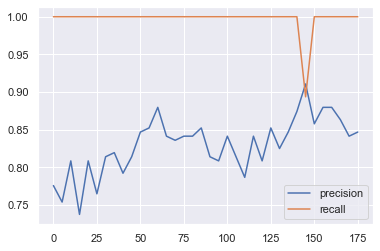

In [5]:
# plot the precision and recall curves
sns.lineplot(range(0, 176, 5), precisions, label='precision')
sns.lineplot(range(0, 176, 5), recalls, label='recall')
plt.legend()

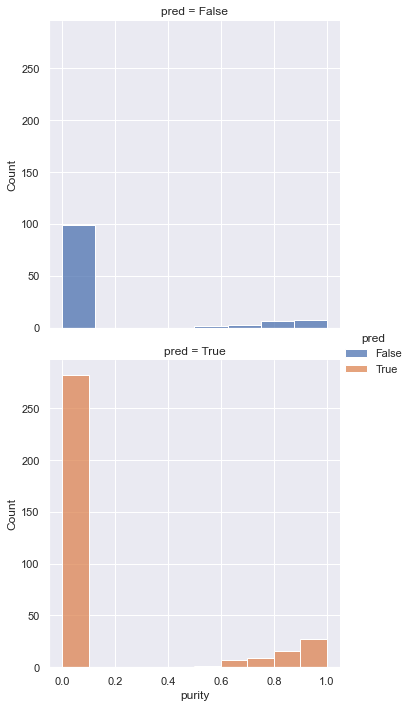

In [13]:
# plot the test attach purities faceted by pred, keep distplot normalized
sns.FacetGrid(purity_pred_df, hue='pred', row='pred', height=5).map(sns.histplot, 'purity').add_legend()